<a href="https://colab.research.google.com/github/mmsamiei/lets-pytorch/blob/master/Q5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  CE-40959: Deep Learning

## Homework 5 - 1: VAE

The goal is to VAE!!!!

Good luck

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

---

In [0]:
CUDA = True
BATCH_SIZE = 128
LEARNING_RATE = 0.01

---

In [0]:
# Reproducibility options

np.random.seed(0)
torch.manual_seed(0)

if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

---

In [0]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

In [0]:
# Define Train loader
train_tensors = original_train_dataset.data.float() / 255
test_tensors = original_test_dataset.data.float() / 255

# Define Datasets
train_dataset = torch.utils.data.TensorDataset(train_tensors, original_train_dataset.targets)
test_dataset = torch.utils.data.TensorDataset(test_tensors, original_test_dataset.targets)

# Define dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

---

In [0]:
class VAE(nn.Module):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims, dropout_rate=0.2):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.z_dim = z_dim
        
        ########################## TODO ##########################
        # self.input_dropout must be a dropout module with p=dropout_rate
        self.dropout = nn.Dropout(dropout_rate)
        ######################## END TODO ########################
        
        # Encoder part
        encoder_layers = []
        ########################## TODO ##########################
        # Define encoder layers and add them to `encoder_layers`
        # Use ReLU for activation functions
        
        temp = encoder_dims
        temp = [input_dim] + temp
        for i in range(len(temp) - 1):
            encoder_layers.append(nn.Linear(temp[i], temp[i + 1]))
            encoder_layers.append(nn.ReLU())
        
        ecoder_hidden_sizes = temp
        
        ######################## END TODO ########################
        self.encoder = nn.Sequential(*encoder_layers)
        
        encoder_last_dim = ([input_dim] + encoder_dims)[-1]
        
        # mu and log_var
        ########################## TODO ##########################
        # Define mu and log_var layers
        # They do not need any activation function
        
        self.mu_layer = nn.Linear(ecoder_hidden_sizes[-1], z_dim)
        self.log_var_layer = nn.Linear(ecoder_hidden_sizes[-1], z_dim)
        
        ######################## END TODO ########################
        
        # Decoder part
        decoder_layers = []
        ########################## TODO ##########################
        # Define decoder layers and add them to `decoder_layers`
        # Use ReLU for activation functions
        # Last layer does not need any activation function
        
        decoder_layers.append(nn.Linear(z_dim, decoder_dims[0]))
        temp = decoder_dims
        temp = temp + [input_dim]
        for i in range(len(temp) - 1):
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Linear(temp[i], temp[i + 1]))
        
        ######################## END TODO ########################
        self.decoder = nn.Sequential(*decoder_layers)

    @staticmethod
    def _sampling(mu, log_var):
        """
        This function is in charge of reparametrization trick
        """
        ########################## TODO ##########################
        # Generate a random z from N(mu=mu, var=e^log_var)
        temp = torch.randn_like(mu)
        z = torch.exp(log_var / 2) * temp + mu
        ######################## END TODO ########################
        return z

    def forward(self, data):
        x = data.get("X")
        ########################## TODO ##########################
        # Complete the flow
        # x > dropout > encoder > mu, log_var > z > decoder > output
        
        temp = x
        temp = self.dropout(temp)
        temp = self.encoder(temp)
        temp_mu = self.mu_layer(temp)
        temp_log_var = self.log_var_layer(temp)
        z = self._sampling(temp_mu, temp_log_var)
        output = self.decoder(z)
        
        ######################## END TODO ########################
        return {"X": output, "mu": temp_mu, "log_var": temp_log_var, "z": z}
    
    def loss(self, data, output):
      x = data.get("X")
      recon_x = output.get("X")
      mu = output.get("mu")
      log_var = output.get("log_var")
      ########################## TODO ##########################
      # Calculate MSE and KLD
      
      error = x - recon_x
      MSE = torch.sum(torch.pow(error, 2))
      KLD = torch.sum(1 + log_var - torch.exp(log_var) - torch.pow(mu, 2)) / -2

      ######################## END TODO ########################
      return {"final": MSE + KLD, "KLD": KLD, "MSE": MSE}

---

In [0]:
def train(model, data_loader, optimizer, epoch="?", print_every=100, verbose=True):
    """
    This function trains a `model` given a `data_loader` by `optimizer`
    """
    model.train()

    train_loss = 0

    for batch_idx, batch_data in enumerate(data_loader):
        supervised_training = len(batch_data) == 2

        if supervised_training:
            # Labeled data
            data = {"X": batch_data[0],
                    "Y": batch_data[1]}
        else:
            # Unlabeled data
            data = {"X": batch_data[0]}

        # Flatten data
        ########################## TODO ##########################
        # Use `flatten` function from pytorch
        data['X'] = torch.flatten(data['X'], start_dim=1)
        ######################## END TODO ########################

        if CUDA:
            ########################## TODO ##########################
            data['X'] = data['X'].to(torch.device('cuda'))
            data['Y'] = data['Y'].to(torch.device('cuda'))
            ######################## END TODO ########################


        ########################## TODO ##########################
        # Think about this part
        ######################## END TODO ########################
        optimizer.zero_grad()

        output = model(data)
        loss = model.loss(data, output)
        final_loss = loss["final"]
        train_loss += final_loss.item()

        final_loss.backward()
        optimizer.step()
        ########################## TODO ##########################
        # Thinking ends here
        ######################## END TODO ########################

        if batch_idx % print_every == 0 and verbose:
            print('Train | Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data["X"]), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), final_loss.item() / len(data["X"])))

    train_loss /= len(data_loader.dataset)
    if verbose:
        print('====> Train | Epoch: {} \t | \t Average loss: {:.4f}'.format(epoch, train_loss,))

    return {"final": train_loss}

In [0]:
def test(model, data_loader, verbose=True):
    """
    This function tests a `model` on a `data_loader`
    """
    model.eval()

    test_loss = 0

    labels, y_preds = None, None
    with torch.no_grad():
        for batch_data  in data_loader:
            supervised = len(batch_data) == 2

            if supervised:
                # Labeled data
                data = {"X": batch_data[0],
                        "Y": batch_data[1]}
            else:
                # Unlabeled data
                data = {"X": batch_data[0]}

            #  Flatten data
            ########################## TODO ##########################
            # Use `flatten` function from pytorch
            data['X'] = torch.flatten(data['X'], start_dim=1)
            ######################## END TODO ########################

            if CUDA:
                ########################## TODO ##########################
                # Send tensors in data to GPU
                data['X'] = data['X'].to(torch.device('cuda'))
                data['Y'] = data['Y'].to(torch.device('cuda'))
                ######################## END TODO ########################

            output = model(data)
            loss = model.loss(data, output)
            final_loss = loss["final"]
            test_loss += final_loss.item()

            # Storing y_true and y_pred if learning is supervised
            supervised = supervised and "Y" in output
            if supervised:
                y_pred = np.argmax(output["Y"].detach().cpu().numpy(), axis=1)
                y_true = data["Y"].cpu().numpy()
                if labels is None:
                    labels = y_true
                    y_preds = y_pred
                else:
                    labels = np.concatenate((labels, y_true), axis=None)
                    y_preds = np.concatenate((y_preds, y_pred), axis=None)

    test_loss /= len(data_loader.dataset)

    if supervised:
        accuracy = accuracy_score(labels, y_preds)
        if verbose:
            print('====> Test  | model loss: {:.4f}'.format(test_loss))
            print('            |   accuracy: {:.4f}'.format(100 * accuracy))
            print(classification_report(labels, y_preds))
        return {"final": test_loss, "accuracy": accuracy}
    else:
        if verbose:
            print('====> Test  | model loss: {:.4f}'.format(test_loss))
        return {"final": test_loss}

In [0]:
def run(model, parameters, n_epoch, train_loader, test_loader,
        end_function=lambda model:None):
    """
    This function will optimize `parameters` of `model` for `n_epoch` epochs
    on `train_loader` dataset and validate it on `test_loader`.
    At the end of each epoch, `end_function` will be called on `model`.
    """
    if CUDA:
        model.cuda()

    ########################## TODO ##########################
    # Initialize a new Adam optimizer.
    # Set learning rate to LEARNING_RATE / BATCH_SIZE (why?)
    lr = LEARNING_RATE / BATCH_SIZE
    optimizer = torch.optim.Adam(params=parameters, lr = lr)
    ######################## END TODO ########################

    for epoch in range(1, n_epoch + 1):
        train_loss = train(model, train_loader, optimizer, epoch)
        test_loss = test(model, test_loader)
        end_function(model)

In [0]:
def show(image_batch, rows=1):
    # Set Plot dimensions
    cols = np.ceil(image_batch.shape[0] / rows)
    plt.rcParams['figure.figsize'] = (0.0 + cols, 0.0 + rows) # set default size of plots
    
    for i in range(image_batch.shape[0]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
        plt.axis('off')
    plt.show()

---

In [47]:
vae = VAE(784, encoder_dims=[512, 128], z_dim=32, decoder_dims=[128, 512])
print(vae)

# Output might be like:
# VAE(
#   (input_dropout): Dropout(p=0.2)
#   (encoder): Sequential(
#     (0): Linear(in_features=784, out_features=512, bias=True)
#     (1): ReLU()
#     (2): Linear(in_features=512, out_features=128, bias=True)
#     (3): ReLU()
#   )
#   (mu_layer): Linear(in_features=128, out_features=32, bias=True)
#   (log_var_layer): Linear(in_features=128, out_features=32, bias=True)
#   (decoder): Sequential(
#     (0): Linear(in_features=32, out_features=128, bias=True)
#     (1): ReLU()
#     (2): Linear(in_features=128, out_features=512, bias=True)
#     (3): ReLU()
#     (4): Linear(in_features=512, out_features=784, bias=True)
#   )
# )

VAE(
  (dropout): Dropout(p=0.2)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
  )
  (mu_layer): Linear(in_features=128, out_features=32, bias=True)
  (log_var_layer): Linear(in_features=128, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [0]:
def show_vae(vae):
    # Select 10 random inputs
    data_loader = train_loader
    indices = torch.randint(data_loader.dataset.tensors[0].shape[0], (10,))
    input_img = data_loader.dataset.tensors[0][indices]
    print("Inputs:")
    show(input_img.numpy())
    # Calculate reconstructions
    input_img = input_img.flatten(start_dim=1)
    if CUDA:
        input_img = input_img.cuda()
    recons_img = vae({"X": input_img})["X"]
    recons_img = recons_img.detach().cpu().view(-1, 28, 28).numpy()
    print("Reconstructions:")
    show(recons_img)
    # Generate images
    z = torch.randn(10, vae.z_dim)
    if CUDA:
        z = z.cuda()
    generated_img = vae.decoder(z)
    generated_img = generated_img.detach().cpu().view(-1, 28, 28).numpy()
    print("Generated Images:")
    show(generated_img)

Train | Epoch: 1 [0/60000 (0%)]	Loss: 93.833641
Train | Epoch: 1 [12800/60000 (21%)]	Loss: 57.368919
Train | Epoch: 1 [25600/60000 (43%)]	Loss: 53.410320
Train | Epoch: 1 [38400/60000 (64%)]	Loss: 51.870415
Train | Epoch: 1 [51200/60000 (85%)]	Loss: 53.079224
====> Train | Epoch: 1 	 | 	 Average loss: 56.1685
====> Test  | model loss: 50.1549
Inputs:


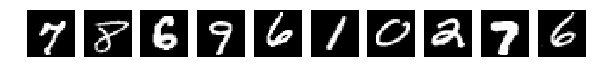

Reconstructions:


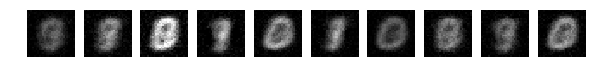

Generated Images:


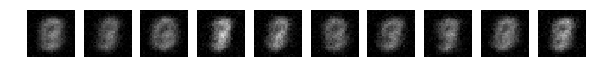

Train | Epoch: 2 [0/60000 (0%)]	Loss: 51.190331
Train | Epoch: 2 [12800/60000 (21%)]	Loss: 49.590763
Train | Epoch: 2 [25600/60000 (43%)]	Loss: 46.584743
Train | Epoch: 2 [38400/60000 (64%)]	Loss: 45.110348
Train | Epoch: 2 [51200/60000 (85%)]	Loss: 43.971455
====> Train | Epoch: 2 	 | 	 Average loss: 46.6940
====> Test  | model loss: 44.4675
Inputs:


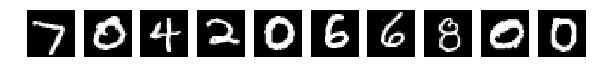

Reconstructions:


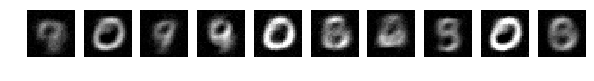

Generated Images:


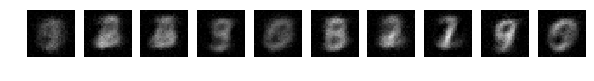

Train | Epoch: 3 [0/60000 (0%)]	Loss: 43.667412
Train | Epoch: 3 [12800/60000 (21%)]	Loss: 45.538044
Train | Epoch: 3 [25600/60000 (43%)]	Loss: 42.725159
Train | Epoch: 3 [38400/60000 (64%)]	Loss: 45.731503
Train | Epoch: 3 [51200/60000 (85%)]	Loss: 41.601166
====> Train | Epoch: 3 	 | 	 Average loss: 43.5367
====> Test  | model loss: 42.1973
Inputs:


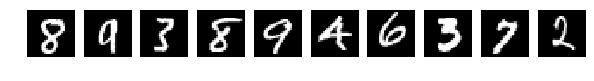

Reconstructions:


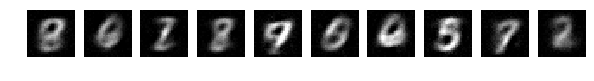

Generated Images:


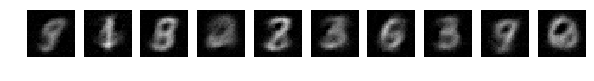

Train | Epoch: 4 [0/60000 (0%)]	Loss: 43.369408
Train | Epoch: 4 [12800/60000 (21%)]	Loss: 43.430405
Train | Epoch: 4 [25600/60000 (43%)]	Loss: 42.120659
Train | Epoch: 4 [38400/60000 (64%)]	Loss: 40.245728
Train | Epoch: 4 [51200/60000 (85%)]	Loss: 41.516300
====> Train | Epoch: 4 	 | 	 Average loss: 41.6171
====> Test  | model loss: 40.4627
Inputs:


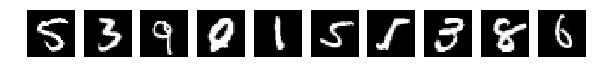

Reconstructions:


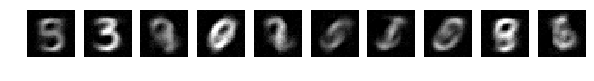

Generated Images:


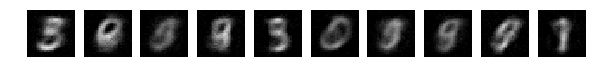

Train | Epoch: 5 [0/60000 (0%)]	Loss: 40.803551
Train | Epoch: 5 [12800/60000 (21%)]	Loss: 39.835026
Train | Epoch: 5 [25600/60000 (43%)]	Loss: 41.678249
Train | Epoch: 5 [38400/60000 (64%)]	Loss: 38.434925
Train | Epoch: 5 [51200/60000 (85%)]	Loss: 39.292210
====> Train | Epoch: 5 	 | 	 Average loss: 40.3270
====> Test  | model loss: 39.2956
Inputs:


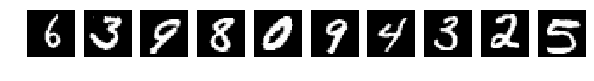

Reconstructions:


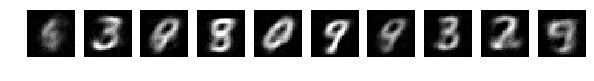

Generated Images:


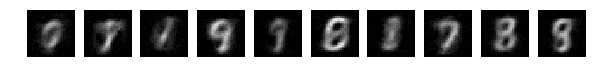

Train | Epoch: 6 [0/60000 (0%)]	Loss: 40.023033
Train | Epoch: 6 [12800/60000 (21%)]	Loss: 41.049911
Train | Epoch: 6 [25600/60000 (43%)]	Loss: 39.786907
Train | Epoch: 6 [38400/60000 (64%)]	Loss: 39.476959
Train | Epoch: 6 [51200/60000 (85%)]	Loss: 40.125286
====> Train | Epoch: 6 	 | 	 Average loss: 39.3347
====> Test  | model loss: 38.2177
Inputs:


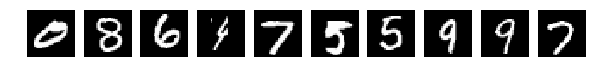

Reconstructions:


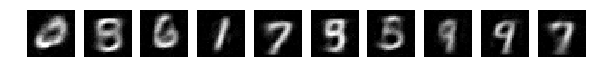

Generated Images:


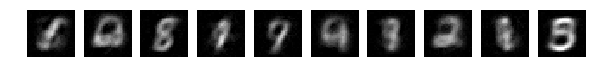

Train | Epoch: 7 [0/60000 (0%)]	Loss: 39.602047
Train | Epoch: 7 [12800/60000 (21%)]	Loss: 38.878258
Train | Epoch: 7 [25600/60000 (43%)]	Loss: 38.372044
Train | Epoch: 7 [38400/60000 (64%)]	Loss: 38.818611
Train | Epoch: 7 [51200/60000 (85%)]	Loss: 38.460571
====> Train | Epoch: 7 	 | 	 Average loss: 38.4537
====> Test  | model loss: 37.4965
Inputs:


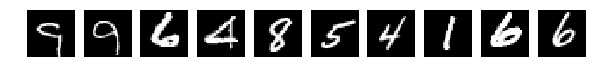

Reconstructions:


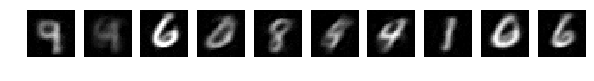

Generated Images:


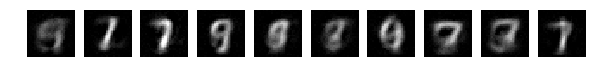

Train | Epoch: 8 [0/60000 (0%)]	Loss: 38.960518
Train | Epoch: 8 [12800/60000 (21%)]	Loss: 37.426445
Train | Epoch: 8 [25600/60000 (43%)]	Loss: 38.226788
Train | Epoch: 8 [38400/60000 (64%)]	Loss: 36.815304
Train | Epoch: 8 [51200/60000 (85%)]	Loss: 36.850342
====> Train | Epoch: 8 	 | 	 Average loss: 37.7170
====> Test  | model loss: 36.7354
Inputs:


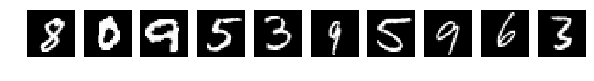

Reconstructions:


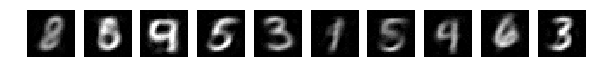

Generated Images:


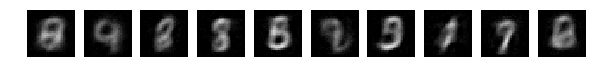

Train | Epoch: 9 [0/60000 (0%)]	Loss: 35.699497
Train | Epoch: 9 [12800/60000 (21%)]	Loss: 37.271225
Train | Epoch: 9 [25600/60000 (43%)]	Loss: 36.761116
Train | Epoch: 9 [38400/60000 (64%)]	Loss: 35.044640
Train | Epoch: 9 [51200/60000 (85%)]	Loss: 38.490562
====> Train | Epoch: 9 	 | 	 Average loss: 37.0643
====> Test  | model loss: 36.1219
Inputs:


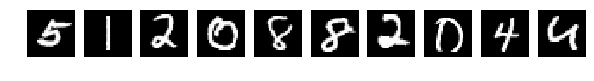

Reconstructions:


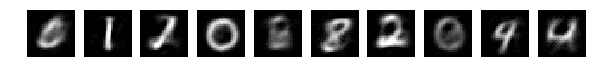

Generated Images:


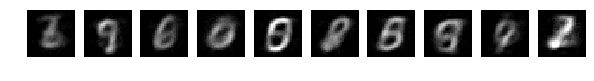

Train | Epoch: 10 [0/60000 (0%)]	Loss: 36.388687
Train | Epoch: 10 [12800/60000 (21%)]	Loss: 35.998516
Train | Epoch: 10 [25600/60000 (43%)]	Loss: 35.997215
Train | Epoch: 10 [38400/60000 (64%)]	Loss: 34.494766
Train | Epoch: 10 [51200/60000 (85%)]	Loss: 36.529888
====> Train | Epoch: 10 	 | 	 Average loss: 36.4826
====> Test  | model loss: 35.6523
Inputs:


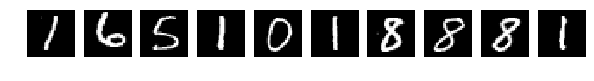

Reconstructions:


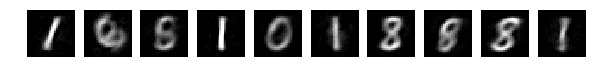

Generated Images:


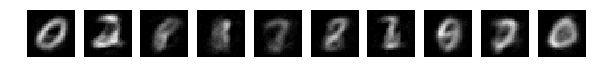

Train | Epoch: 11 [0/60000 (0%)]	Loss: 37.726070
Train | Epoch: 11 [12800/60000 (21%)]	Loss: 35.922451
Train | Epoch: 11 [25600/60000 (43%)]	Loss: 37.453789
Train | Epoch: 11 [38400/60000 (64%)]	Loss: 35.948322
Train | Epoch: 11 [51200/60000 (85%)]	Loss: 35.448486
====> Train | Epoch: 11 	 | 	 Average loss: 35.9234
====> Test  | model loss: 35.1302
Inputs:


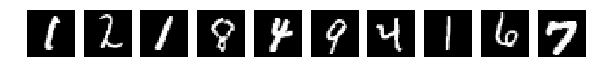

Reconstructions:


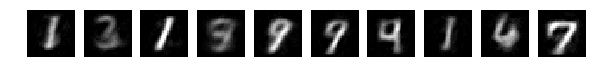

Generated Images:


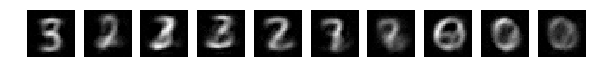

Train | Epoch: 12 [0/60000 (0%)]	Loss: 35.380947
Train | Epoch: 12 [12800/60000 (21%)]	Loss: 35.366375
Train | Epoch: 12 [25600/60000 (43%)]	Loss: 34.685066
Train | Epoch: 12 [38400/60000 (64%)]	Loss: 35.243683
Train | Epoch: 12 [51200/60000 (85%)]	Loss: 35.698620
====> Train | Epoch: 12 	 | 	 Average loss: 35.4178
====> Test  | model loss: 34.5512
Inputs:


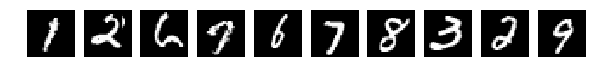

Reconstructions:


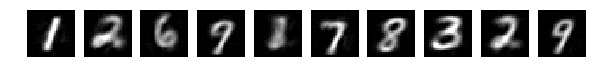

Generated Images:


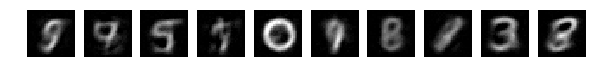

Train | Epoch: 13 [0/60000 (0%)]	Loss: 36.503761
Train | Epoch: 13 [12800/60000 (21%)]	Loss: 35.936062
Train | Epoch: 13 [25600/60000 (43%)]	Loss: 35.576355
Train | Epoch: 13 [38400/60000 (64%)]	Loss: 33.985355
Train | Epoch: 13 [51200/60000 (85%)]	Loss: 35.225266
====> Train | Epoch: 13 	 | 	 Average loss: 35.0075
====> Test  | model loss: 34.1231
Inputs:


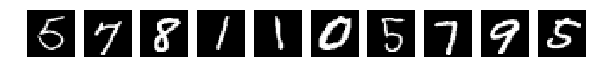

Reconstructions:


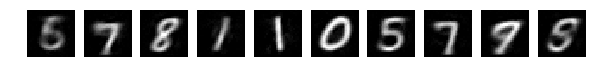

Generated Images:


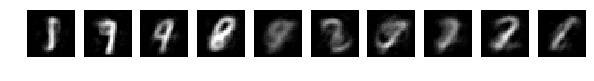

Train | Epoch: 14 [0/60000 (0%)]	Loss: 35.184196
Train | Epoch: 14 [12800/60000 (21%)]	Loss: 34.561691
Train | Epoch: 14 [25600/60000 (43%)]	Loss: 34.054363
Train | Epoch: 14 [38400/60000 (64%)]	Loss: 35.589977
Train | Epoch: 14 [51200/60000 (85%)]	Loss: 34.464836
====> Train | Epoch: 14 	 | 	 Average loss: 34.5868
====> Test  | model loss: 33.8228
Inputs:


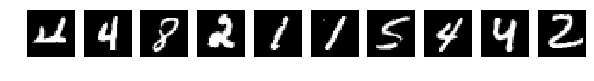

Reconstructions:


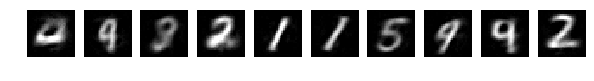

Generated Images:


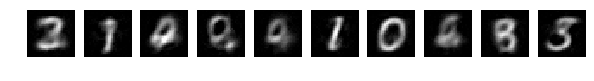

Train | Epoch: 15 [0/60000 (0%)]	Loss: 35.166725
Train | Epoch: 15 [12800/60000 (21%)]	Loss: 32.660587
Train | Epoch: 15 [25600/60000 (43%)]	Loss: 35.145348
Train | Epoch: 15 [38400/60000 (64%)]	Loss: 33.742588
Train | Epoch: 15 [51200/60000 (85%)]	Loss: 33.626434
====> Train | Epoch: 15 	 | 	 Average loss: 34.2924
====> Test  | model loss: 33.5316
Inputs:


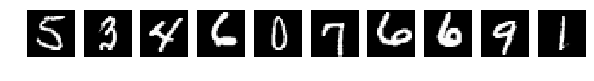

Reconstructions:


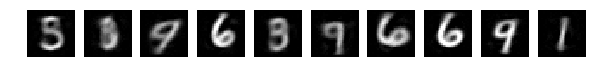

Generated Images:


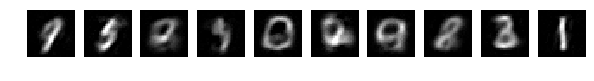

Train | Epoch: 16 [0/60000 (0%)]	Loss: 34.637650
Train | Epoch: 16 [12800/60000 (21%)]	Loss: 32.857491
Train | Epoch: 16 [25600/60000 (43%)]	Loss: 33.545067
Train | Epoch: 16 [38400/60000 (64%)]	Loss: 33.999191
Train | Epoch: 16 [51200/60000 (85%)]	Loss: 35.703880
====> Train | Epoch: 16 	 | 	 Average loss: 33.9962
====> Test  | model loss: 33.1933
Inputs:


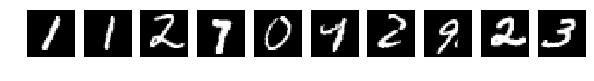

Reconstructions:


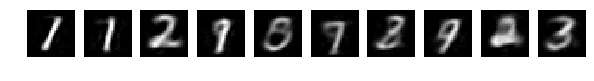

Generated Images:


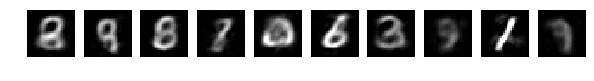

Train | Epoch: 17 [0/60000 (0%)]	Loss: 34.779232
Train | Epoch: 17 [12800/60000 (21%)]	Loss: 32.564854
Train | Epoch: 17 [25600/60000 (43%)]	Loss: 34.382790
Train | Epoch: 17 [38400/60000 (64%)]	Loss: 32.999817
Train | Epoch: 17 [51200/60000 (85%)]	Loss: 34.370026
====> Train | Epoch: 17 	 | 	 Average loss: 33.7283
====> Test  | model loss: 32.9245
Inputs:


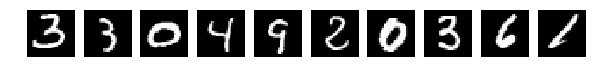

Reconstructions:


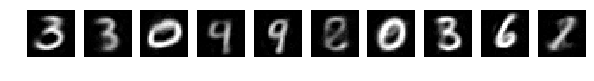

Generated Images:


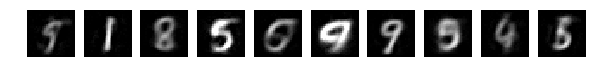

Train | Epoch: 18 [0/60000 (0%)]	Loss: 34.033474
Train | Epoch: 18 [12800/60000 (21%)]	Loss: 34.035591
Train | Epoch: 18 [25600/60000 (43%)]	Loss: 32.256279
Train | Epoch: 18 [38400/60000 (64%)]	Loss: 33.957588
Train | Epoch: 18 [51200/60000 (85%)]	Loss: 33.645538
====> Train | Epoch: 18 	 | 	 Average loss: 33.4817
====> Test  | model loss: 32.7192
Inputs:


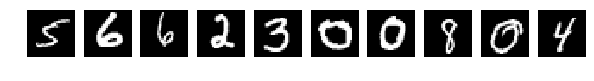

Reconstructions:


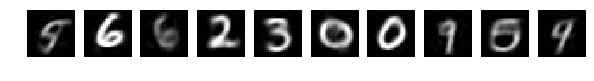

Generated Images:


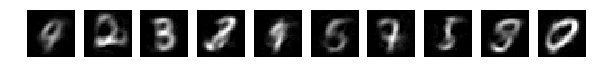

Train | Epoch: 19 [0/60000 (0%)]	Loss: 33.285149
Train | Epoch: 19 [12800/60000 (21%)]	Loss: 33.321365
Train | Epoch: 19 [25600/60000 (43%)]	Loss: 33.323696
Train | Epoch: 19 [38400/60000 (64%)]	Loss: 33.413696
Train | Epoch: 19 [51200/60000 (85%)]	Loss: 33.274891
====> Train | Epoch: 19 	 | 	 Average loss: 33.2731
====> Test  | model loss: 32.4997
Inputs:


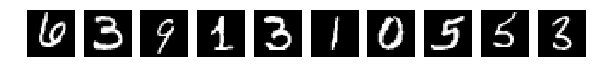

Reconstructions:


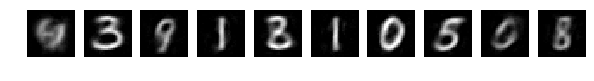

Generated Images:


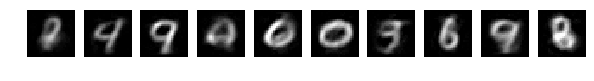

Train | Epoch: 20 [0/60000 (0%)]	Loss: 32.413479
Train | Epoch: 20 [12800/60000 (21%)]	Loss: 31.891785
Train | Epoch: 20 [25600/60000 (43%)]	Loss: 33.507198
Train | Epoch: 20 [38400/60000 (64%)]	Loss: 31.354809
Train | Epoch: 20 [51200/60000 (85%)]	Loss: 32.926781
====> Train | Epoch: 20 	 | 	 Average loss: 33.0734
====> Test  | model loss: 32.4116
Inputs:


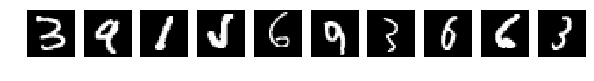

Reconstructions:


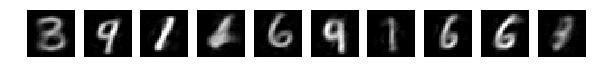

Generated Images:


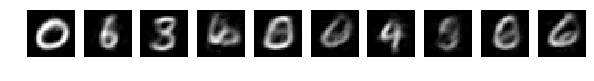

Train | Epoch: 21 [0/60000 (0%)]	Loss: 33.752182
Train | Epoch: 21 [12800/60000 (21%)]	Loss: 34.565025
Train | Epoch: 21 [25600/60000 (43%)]	Loss: 32.124031
Train | Epoch: 21 [38400/60000 (64%)]	Loss: 32.024376
Train | Epoch: 21 [51200/60000 (85%)]	Loss: 33.061485
====> Train | Epoch: 21 	 | 	 Average loss: 32.9094
====> Test  | model loss: 32.1387
Inputs:


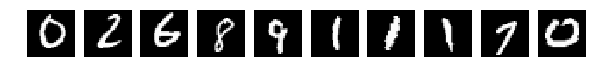

Reconstructions:


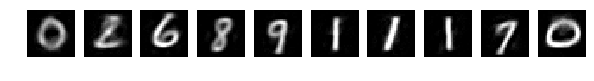

Generated Images:


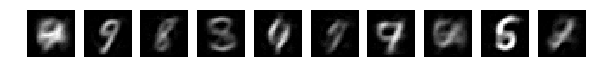

Train | Epoch: 22 [0/60000 (0%)]	Loss: 32.917587
Train | Epoch: 22 [12800/60000 (21%)]	Loss: 32.483166
Train | Epoch: 22 [25600/60000 (43%)]	Loss: 31.944912
Train | Epoch: 22 [38400/60000 (64%)]	Loss: 31.774927
Train | Epoch: 22 [51200/60000 (85%)]	Loss: 30.614391
====> Train | Epoch: 22 	 | 	 Average loss: 32.7273
====> Test  | model loss: 32.0751
Inputs:


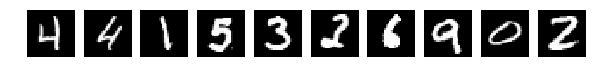

Reconstructions:


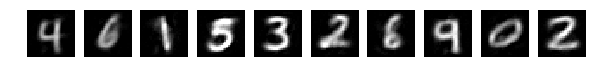

Generated Images:


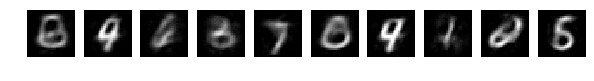

Train | Epoch: 23 [0/60000 (0%)]	Loss: 32.747929
Train | Epoch: 23 [12800/60000 (21%)]	Loss: 32.553314
Train | Epoch: 23 [25600/60000 (43%)]	Loss: 31.935242
Train | Epoch: 23 [38400/60000 (64%)]	Loss: 34.301575
Train | Epoch: 23 [51200/60000 (85%)]	Loss: 33.855534
====> Train | Epoch: 23 	 | 	 Average loss: 32.5923
====> Test  | model loss: 31.8898
Inputs:


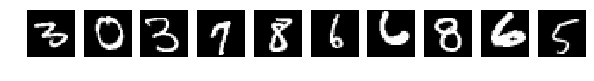

Reconstructions:


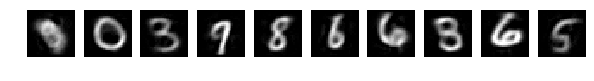

Generated Images:


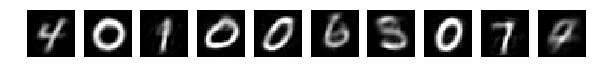

Train | Epoch: 24 [0/60000 (0%)]	Loss: 32.351185
Train | Epoch: 24 [12800/60000 (21%)]	Loss: 33.150631
Train | Epoch: 24 [25600/60000 (43%)]	Loss: 31.711212
Train | Epoch: 24 [38400/60000 (64%)]	Loss: 32.674084
Train | Epoch: 24 [51200/60000 (85%)]	Loss: 30.704872
====> Train | Epoch: 24 	 | 	 Average loss: 32.4171
====> Test  | model loss: 31.7783
Inputs:


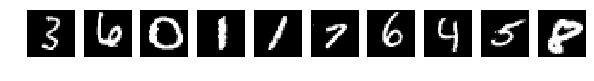

Reconstructions:


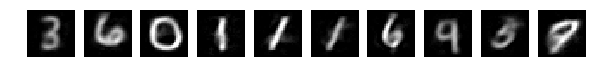

Generated Images:


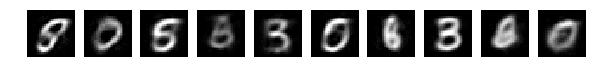

Train | Epoch: 25 [0/60000 (0%)]	Loss: 32.479397
Train | Epoch: 25 [12800/60000 (21%)]	Loss: 32.343338
Train | Epoch: 25 [25600/60000 (43%)]	Loss: 32.915745
Train | Epoch: 25 [38400/60000 (64%)]	Loss: 32.149590
Train | Epoch: 25 [51200/60000 (85%)]	Loss: 32.867428
====> Train | Epoch: 25 	 | 	 Average loss: 32.3000
====> Test  | model loss: 31.6714
Inputs:


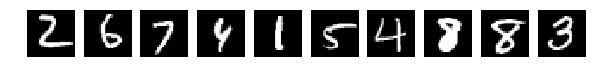

Reconstructions:


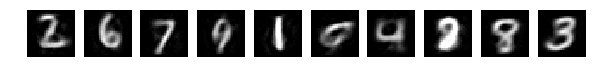

Generated Images:


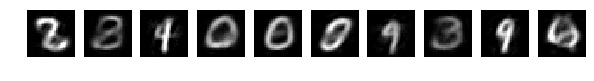

Train | Epoch: 26 [0/60000 (0%)]	Loss: 32.017853
Train | Epoch: 26 [12800/60000 (21%)]	Loss: 31.430254
Train | Epoch: 26 [25600/60000 (43%)]	Loss: 32.202438
Train | Epoch: 26 [38400/60000 (64%)]	Loss: 31.196398
Train | Epoch: 26 [51200/60000 (85%)]	Loss: 32.068150
====> Train | Epoch: 26 	 | 	 Average loss: 32.1817
====> Test  | model loss: 31.4907
Inputs:


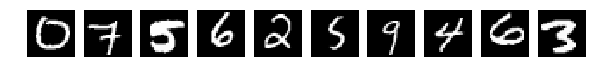

Reconstructions:


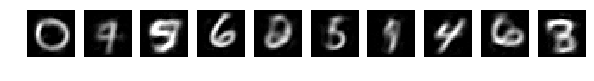

Generated Images:


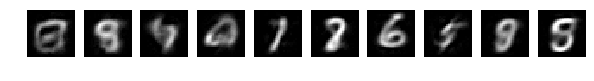

Train | Epoch: 27 [0/60000 (0%)]	Loss: 31.852188
Train | Epoch: 27 [12800/60000 (21%)]	Loss: 31.492260
Train | Epoch: 27 [25600/60000 (43%)]	Loss: 30.556589
Train | Epoch: 27 [38400/60000 (64%)]	Loss: 33.060944
Train | Epoch: 27 [51200/60000 (85%)]	Loss: 31.970127
====> Train | Epoch: 27 	 | 	 Average loss: 32.0790
====> Test  | model loss: 31.3965
Inputs:


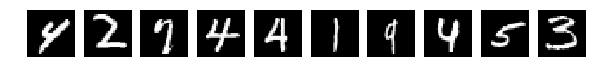

Reconstructions:


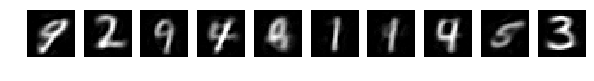

Generated Images:


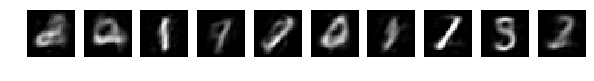

Train | Epoch: 28 [0/60000 (0%)]	Loss: 32.415470
Train | Epoch: 28 [12800/60000 (21%)]	Loss: 31.209435
Train | Epoch: 28 [25600/60000 (43%)]	Loss: 31.453381
Train | Epoch: 28 [38400/60000 (64%)]	Loss: 33.272324
Train | Epoch: 28 [51200/60000 (85%)]	Loss: 31.675610
====> Train | Epoch: 28 	 | 	 Average loss: 31.9802
====> Test  | model loss: 31.3168
Inputs:


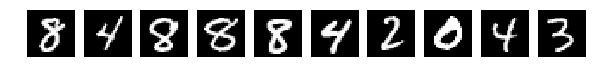

Reconstructions:


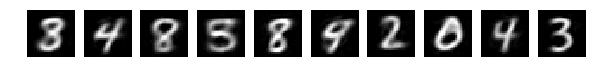

Generated Images:


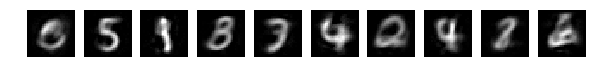

Train | Epoch: 29 [0/60000 (0%)]	Loss: 32.518478
Train | Epoch: 29 [12800/60000 (21%)]	Loss: 32.314766
Train | Epoch: 29 [25600/60000 (43%)]	Loss: 30.571865
Train | Epoch: 29 [38400/60000 (64%)]	Loss: 30.634277
Train | Epoch: 29 [51200/60000 (85%)]	Loss: 32.486855
====> Train | Epoch: 29 	 | 	 Average loss: 31.8377
====> Test  | model loss: 31.2065
Inputs:


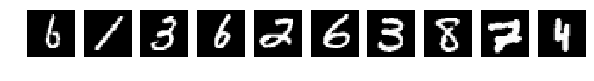

Reconstructions:


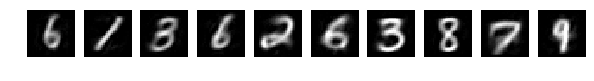

Generated Images:


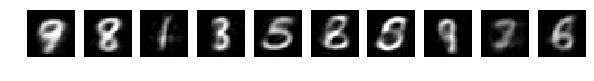

Train | Epoch: 30 [0/60000 (0%)]	Loss: 32.416229
Train | Epoch: 30 [12800/60000 (21%)]	Loss: 31.470245
Train | Epoch: 30 [25600/60000 (43%)]	Loss: 30.385845
Train | Epoch: 30 [38400/60000 (64%)]	Loss: 32.768070
Train | Epoch: 30 [51200/60000 (85%)]	Loss: 30.069168
====> Train | Epoch: 30 	 | 	 Average loss: 31.7464
====> Test  | model loss: 31.1363
Inputs:


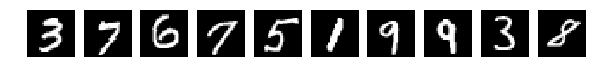

Reconstructions:


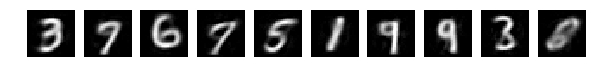

Generated Images:


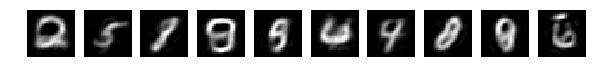

In [49]:
n_epoch = 30
run(vae, vae.parameters(), n_epoch, train_loader, test_loader,
   end_function=show_vae)

---

In [0]:
def check_interpolations(model, n_rows, n_cols):
    """
    Write a function which interpolates 10 images between two random mnist image
    """
    plt.rcParams['figure.figsize'] = (0.0 + n_cols, 0.0 + n_rows) # set default size of plots
    
    data_loader = train_loader
    
    for _ in range(n_rows):
        indices = torch.randint(data_loader.dataset.tensors[0].shape[0], (2,))
        img_1 = data_loader.dataset.tensors[0][indices][:1].flatten(start_dim=1)
        img_2 = data_loader.dataset.tensors[0][indices][1:].flatten(start_dim=1)
        
        ########################## TODO ##########################
        # Output `n_cols` images.
        # First one should be img_1. Last one should by img_2
        # Let z_1 and z_2 be latent tensors of img_1 and img_2
        # Interpolate (n_cols - 2) tensors between z_1 and z_2
        # Intermediate images must be the result of applying decoder on these (n_cols - 2) tensors
        z_1 = model.forward({'X' :img_1.cuda()})['z']
        z_2 = model.forward({'X' :img_2.cuda()})['z']
        interpolateds_of_z = []
        for i in range(0,n_cols+1):
          intepolated_of_z = (i) / (n_cols + 1) * z_2 + (n_cols - i) / (n_cols + 1) * z_1
          interpolateds_of_z.append(intepolated_of_z)
        
        output = []
        for i in range(len(interpolateds_of_z)):
            interpolated = model.decoder(interpolateds_of_z[i])
            output.append(interpolated.view(28, 28).cpu().detach().numpy())
        output = np.array(output)
        ######################## END TODO ########################
        
        show(output)

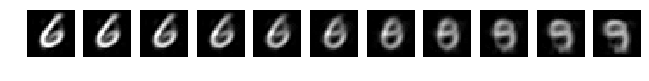

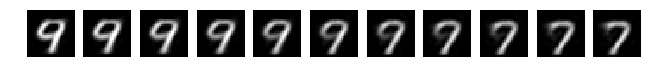

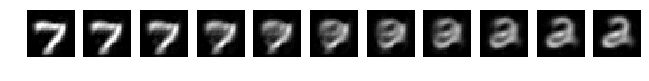

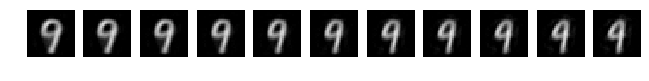

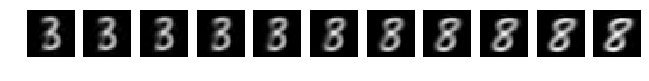

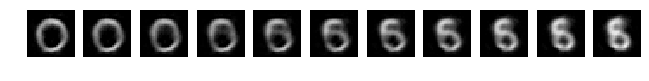

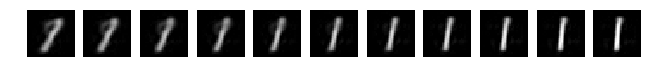

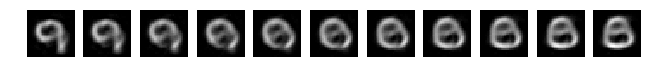

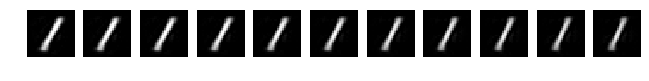

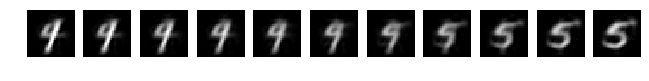

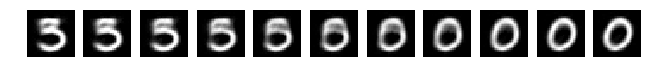

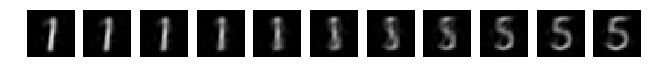

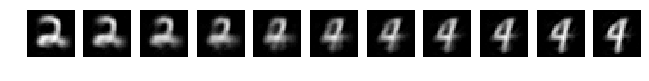

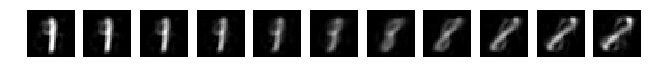

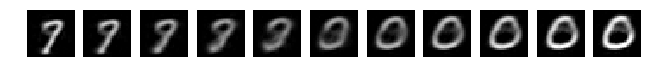

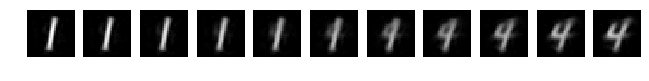

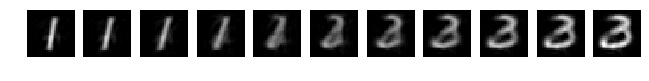

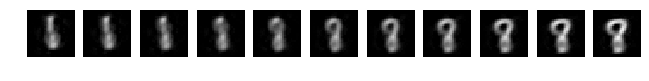

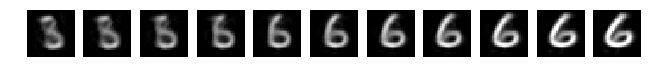

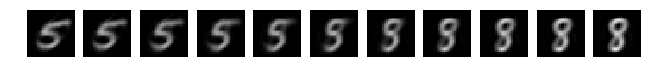

In [55]:
check_interpolations(vae, 20, 10)